In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import pytorch_lightning as pl
import datasets
import numpy as np

pl.seed_everything(89026614)

text = datasets.load_dataset('tiny_shakespeare')["train"][0]["text"]
#text = open('../../Downloads/simplebooks/simplebooks-2-raw/train.txt', 'r').read()

Global seed set to 89026614
Found cached dataset tiny_shakespeare (/Users/cztomsik/.cache/huggingface/datasets/tiny_shakespeare/default/1.0.0/b5b13969f09fe8707337f6cb296314fbe06960bd9a868dca39e713e163d27b5e)
100%|██████████| 3/3 [00:00<00:00, 1293.61it/s]


In [27]:
device = "cpu"
block_size = 64
test_size = 1500

class MyDataset(data.Dataset):
    def __init__(self, text):
        super().__init__()
        vocab = sorted(set(text))
        self.vocab = vocab
        self.stoi = { ch: i for i, ch in enumerate(vocab) }
        self.itos = { i: ch for i, ch in enumerate(vocab) }
        self.data = torch.tensor([self.stoi[ch] for ch in text], dtype=torch.long).to(device)

    def __len__(self):
        return self.data.size(0) - block_size - 1

    def __getitem__(self, i):
        end = i + block_size
        return self.data[i:end], self.data[i + 1:end + 1]

dataset = MyDataset(text)
train = data.Subset(dataset, range(0, len(dataset) - test_size))
test = data.Subset(dataset, range(len(dataset) - test_size, len(dataset)))

In [28]:
# inspired by https://github.com/karpathy/minGPT/blob/master/mingpt/model.py
class MinGPT(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_layers):
        super().__init__()
        self.transformer = nn.Sequential(
            nn.Embedding(vocab_size, embed_dim),
            nn.Sequential(*[DecoderLayer(embed_dim) for _ in range(num_layers)]),
            nn.LayerNorm(embed_dim),
        )
        self.lm_head = nn.Linear(embed_dim, vocab_size, bias=False)
    
    def forward(self, x):
        return self.lm_head(self.transformer(x))

    @torch.no_grad()
    def generate(self, input_ids, max_new_tokens, top_k=10):
        for _ in range(max_new_tokens):
            out = self(input_ids[:, -block_size:])
            logits = out[:, -1, :]
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float("Inf")
            step_res = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1)
            # auto-regression
            input_ids = torch.cat((input_ids, step_res), dim=1)

        return input_ids

class DecoderLayer(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_dim)
        self.attn = AFTFlat(embed_dim)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.GELU(approximate="tanh"),
            nn.Linear(4 * embed_dim, embed_dim)
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

# inspired by https://arxiv.org/pdf/2105.14103.pdf and https://github.com/BlinkDL/RWKV-LM
class AFTFlat(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.w = nn.Parameter(torch.arange(-block_size, 0, dtype=torch.float).unsqueeze(1), requires_grad=True)
    
    def forward(self, x):
        B, T, C = x.shape
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        # TODO: figure out real bounds (stability)
        k = k.clamp(min=-20,max=20).exp()
        w = self.w[-T:].exp()
        Yt = F.sigmoid(q) * torch.cumsum(w * k * v, dim=1) / torch.cumsum(w * k, dim=1)
        return self.proj(Yt)

class Model(pl.LightningModule):
    def __init__(self, vocab_size, lr=0.007):
        super().__init__()
        self.lr = lr
        self.model = MinGPT(vocab_size, embed_dim=44, num_layers=5)
    
    def forward(self, x, y=None):
        logits = self.model(x)
        return logits if y is None else F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1)

    def train_dataloader(self):
        return data.DataLoader(train, batch_size=block_size, num_workers=0, sampler=data.RandomSampler(train, False, 6_000))

    def training_step(self, batch, batch_idx):
        return self(*batch)

    def val_dataloader(self):
        return data.DataLoader(test, batch_size=block_size, num_workers=0)
    
    def validation_step(self, batch, batch_idx):
        loss = self(*batch)
        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_epoch_end(self, outs):
        with torch.no_grad():
            x = torch.tensor([dataset.stoi[s] for s in "And now "], dtype=torch.long)[None,...].to(device)
            y = self.model.generate(x, 64)[0]
            print("".join([dataset.itos[int(i)] for i in y]))

    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters(), lr=self.lr)
        sched = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.999, last_epoch=-1)
        return [optim], [sched]

model = Model(len(dataset.vocab))
trainer = pl.Trainer(max_epochs=25, enable_progress_bar=True, accelerator="gpu" if device == "cuda" else "cpu")
trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type   | Params
---------------------------------
0 | model | MinGPT | 124 K 
---------------------------------
124 K     Trainable params
0         Non-trainable params
124 K     Total params
0.497     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 43.80it/s]

/Users/cztomsik/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/cztomsik/miniconda3/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


And now Np,KSvYTclAOY!Rp.PF.'iOcp..BPCjHBbpDS&NpaECwFXVl'&zFor'lM?O;I&Ua
                                                                           

/Users/cztomsik/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 118/118 [00:05<00:00, 20.89it/s, loss=2.07, v_num=236]And now have to be tor with sip parters blond in thus pone
Bant oft, I h
Epoch 1: 100%|██████████| 118/118 [00:05<00:00, 20.91it/s, loss=1.82, v_num=236, test_loss=2.080]And now what they am
To love well
To ath with peill me the more; and the
Epoch 2: 100%|██████████| 118/118 [00:05<00:00, 20.72it/s, loss=1.7, v_num=236, test_loss=1.890] And now whomen!
For every or will, say thy wong,
And iscall bield to sho
Epoch 3: 100%|██████████| 118/118 [00:05<00:00, 20.87it/s, loss=1.62, v_num=236, test_loss=1.840]And now will mine all
To look and from the king thrat of your
hophind of
Epoch 4: 100%|██████████| 118/118 [00:05<00:00, 20.67it/s, loss=1.6, v_num=236, test_loss=1.750] And now such'd that,
See arm me thou anth batter to do thumb a was; when
Epoch 5: 100%|██████████| 118/118 [00:05<00:00, 20.84it/s, loss=1.56, v_num=236, test_loss=1.730]And now our too,
And by all be than I tender than mile fulfie.

God I 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 118/118 [00:06<00:00, 16.91it/s, loss=1.41, v_num=236, test_loss=1.500]


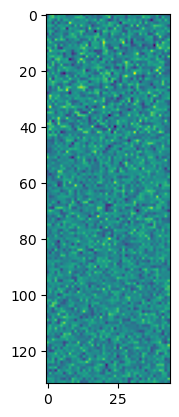

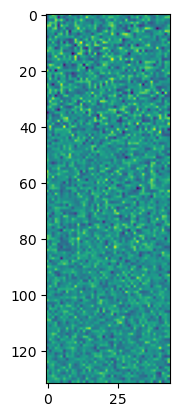

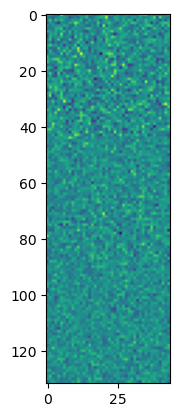

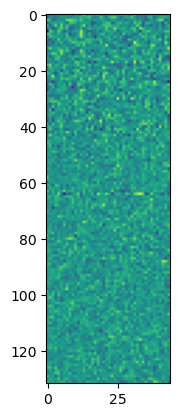

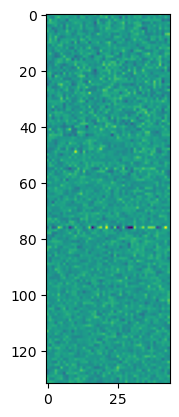

In [29]:
from matplotlib import pyplot as plt
for b in model.model.transformer[1]:
    plt.figure()
    plt.imshow(b.attn.qkv.weight.detach())

In [30]:
y = model.to(device).model.generate(torch.tensor([dataset.stoi[s] for s in "O God, O God!".rjust(block_size)]).unsqueeze(0).to(device), 650)
print("".join([dataset.itos[int(i)] for i in y[0]]))

                                                   O God, O God!
It was the more it: have be busiful:
But have, I may lay it a boy.
Can all in help to sed we heavy be be busine:
It seems'd must starce will holy torne the deputy?

PENponeZith a purning away.

CLARENCE:
Where you the farther this; for thou be strew-my blood.

Servant:
I must be the sent a confessive the tedious to will be sullens,
To and misford so hither swear. I should there the most sword.

LARTIUS:
I buy both before her so hummont to deserful times; or I spirit
Thy foot within him them something of the duke's.

LUCIO:
O, and thou but all the stirrah,,
That the tire with our faults a pinces, weep wast;
Of all an hour of the parish force 
